# BenchFS IOR Result Visualizer

`results/benchfs/*/ior_results/ior_result_*.json` から IOR のサマリ JSON を読み込み、操作別の帯域やレイテンシを可視化します。

In [1]:
from pathlib import Path
import json
import re

import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from IPython.display import display

# Plot style configuration
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.grid": True,
    "grid.alpha": 0.3,
})
pl.Config.set_tbl_rows(100)

DATA_DIR = (Path.cwd() / "processed" / "benchfsd").resolve()
DATA_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = (Path.cwd() / "fig" / "benchfsd").resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)

def save(fig, name: str) -> None:
    for ext in ("png", "pdf"):
        fig.savefig(FIG_DIR / f"{name}.{ext}", bbox_inches="tight", dpi=150)

def comma_formatter(value, _):
    return f"{value:,.0f}"

def slugify(value: str) -> str:
    cleaned = re.sub(r"[^A-Za-z0-9._-]+", "_", value)
    return cleaned.strip("_") or "unknown"

In [2]:
def resolve_results_root() -> Path:
    candidates = [
        Path("results"),
        Path("..") / "results",
        Path("../..") / "results",
    ]
    for candidate in candidates:
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError("results ディレクトリが見つかりません。ノートブックの位置を確認してください。")

results_root = resolve_results_root()
print(f"Using results directory: {results_root}")

Using results directory: /work/0/NBB/rmaeda/workspace/rust/benchfs/results


In [3]:
def fix_ior_json(content: str) -> str:
    """Fix common IOR JSON output format bugs.
    
    IOR 4.0.0 has several JSON formatting issues:
    1. Double closing brackets after Results array: ]] -> ]
    2. Extra closing bracket at the end of tests array
    3. Trailing commas before closing braces/brackets
    """
    # Issue 1: Double closing bracket after Results array
    # Pattern: "Results": [ ... ]] , "max":
    content = re.sub(r'\]\s*\]\s*,\s*"max":', r'], "max":', content)
    
    # Issue 2: Extra closing bracket at the end of tests array  
    # Pattern: }]] , "summary": -> }] , "summary":
    content = re.sub(r'\}\s*\]\s*\]\s*,\s*"summary":', r'}], "summary":', content)
    
    # Issue 3: Trailing comma before closing brace
    content = re.sub(r',\s*\}', '}', content)
    
    # Issue 4: Trailing comma before closing bracket
    content = re.sub(r',\s*\]', ']', content)
    
    return content

def safe_load_json(path: Path) -> dict | None:
    """Load JSON file with automatic fix for IOR format issues."""
    try:
        content = path.read_text()
        # Try parsing as-is first
        try:
            return json.loads(content)
        except json.JSONDecodeError:
            pass
        # Apply fixes and retry
        fixed_content = fix_ior_json(content)
        return json.loads(fixed_content)
    except (OSError, json.JSONDecodeError) as exc:
        print(f"⚠️ Failed to parse {path}: {exc}")
        return None

In [4]:
IOR_JSON_PATTERN = re.compile(r"ior_result_(\d+)\.json$")

def parse_number(value):
    if value is None:
        return None
    if isinstance(value, (int, float)):
        return float(value)
    if isinstance(value, str):
        cleaned = value.replace(",", "").strip()
        if cleaned == "":
            return None
        try:
            return float(cleaned)
        except ValueError:
            return None
    return None

def parse_size(size_str: str) -> int | None:
    """Parse size string like '4m', '512m', '1g' to bytes."""
    if not size_str:
        return None
    size_str = size_str.lower().strip()
    multipliers = {'k': 1024, 'm': 1024**2, 'g': 1024**3, 't': 1024**4}
    for suffix, mult in multipliers.items():
        if size_str.endswith(suffix):
            try:
                return int(float(size_str[:-1]) * mult)
            except ValueError:
                return None
    try:
        return int(size_str)
    except ValueError:
        return None

def extract_params_from_command(command: str) -> dict:
    """Extract IOR parameters from command line string."""
    params = {}
    # Transfer size: -t 4m
    match = re.search(r'-t\s+(\S+)', command)
    if match:
        params['transfer_size_str'] = match.group(1)
    # Block size: -b 512m
    match = re.search(r'-b\s+(\S+)', command)
    if match:
        params['block_size_str'] = match.group(1)
    # File per proc: -F flag
    params['file_per_proc'] = 1 if ' -F' in command or command.endswith('-F') else 0
    return params

def load_ior_json(root: Path) -> tuple[pl.DataFrame, pl.DataFrame]:
    summary_records = []
    detail_records = []
    
    for path in sorted(root.glob("**/ior_results/ior_result_*.json")):
        data = safe_load_json(path)
        if data is None:
            continue
            
        rel_parts = path.relative_to(root).parts
        match = IOR_JSON_PATTERN.search(path.name)
        run_index = int(match.group(1)) if match else None
        
        command = data.get("Command line", "")
        cmd_params = extract_params_from_command(command)
        
        base = {
            "ior_file": str(path.relative_to(root)),
            "collection": "/".join(rel_parts[:-1]),
            "backend": rel_parts[0] if len(rel_parts) > 0 else "",
            "experiment": rel_parts[1] if len(rel_parts) > 1 else "",
            "run": rel_parts[2] if len(rel_parts) > 2 else "",
            "run_index": run_index,
        }
        
        began = data.get("Began", "")
        finished = data.get("Finished", "")
        
        for summary in data.get("summary", []) or []:
            record = base | {
                "command": command,
                "began": began,
                "finished": finished,
                "operation": summary.get("operation"),
                "bw_max_mib": parse_number(summary.get("bwMaxMIB")),
                "bw_min_mib": parse_number(summary.get("bwMinMIB")),
                "bw_mean_mib": parse_number(summary.get("bwMeanMIB")),
                "bw_std_mib": parse_number(summary.get("bwStdMIB")),
                "ops_max": parse_number(summary.get("OPsMax")),
                "ops_min": parse_number(summary.get("OPsMin")),
                "ops_mean": parse_number(summary.get("OPsMean")),
                "ops_std": parse_number(summary.get("OPsSD")),
                "mean_time": parse_number(summary.get("MeanTime")),
                "xsize_mib": parse_number(summary.get("xsizeMiB")),
                "block_size_bytes": parse_number(summary.get("blockSize")),
                "transfer_size_bytes": parse_number(summary.get("transferSize")),
                "segment_count": summary.get("segmentCount"),
                "num_tasks": summary.get("numTasks"),
                "tasks_per_node": summary.get("tasksPerNode"),
                "repetitions": summary.get("repetitions"),
                "file_per_proc": summary.get("filePerProc"),
                "transfer_size_str": cmd_params.get("transfer_size_str", ""),
                "block_size_str": cmd_params.get("block_size_str", ""),
            }
            summary_records.append(record)
            
        for test in data.get("tests", []) or []:
            parameters = test.get("Parameters", {}) or {}
            options = test.get("Options", {}) or {}
            results = test.get("Results", []) or []
            
            for result in results:
                if result.get("access") == "remove":
                    continue  # Skip remove operations
                detail_record = base | {
                    "command": command,
                    "test_id": test.get("TestID"),
                    "start_time": test.get("StartTime"),
                    "path": test.get("Path"),
                    "operation": result.get("access"),
                    "bw_mib": parse_number(result.get("bwMiB")),
                    "iops": parse_number(result.get("iops")),
                    "latency": parse_number(result.get("latency")),
                    "open_time": parse_number(result.get("openTime")),
                    "transfer_time": parse_number(result.get("wrRdTime")),
                    "close_time": parse_number(result.get("closeTime")),
                    "total_time": parse_number(result.get("totalTime")),
                    "block_kib": parse_number(result.get("blockKiB")),
                    "xfer_kib": parse_number(result.get("xferKiB")),
                    "segment_count": parameters.get("segmentCount"),
                    "transfer_size_bytes": parameters.get("transferSize"),
                    "block_size_bytes": parameters.get("blockSize"),
                    "num_tasks": options.get("tasks"),
                    "nodes": options.get("nodes"),
                    "tasks_per_node": options.get("clients per node"),
                    "transfer_size_str": cmd_params.get("transfer_size_str", ""),
                    "block_size_str": cmd_params.get("block_size_str", ""),
                    "file_per_proc": cmd_params.get("file_per_proc", 0),
                }
                detail_records.append(detail_record)
                
    summary_df = pl.DataFrame(summary_records) if summary_records else pl.DataFrame([])
    
    if not summary_df.is_empty():
        summary_df = (
            summary_df
            .with_columns(
                pl.col("num_tasks").cast(pl.Int64, strict=False),
                pl.col("tasks_per_node").cast(pl.Int64, strict=False),
                pl.col("repetitions").cast(pl.Int64, strict=False),
                pl.col("file_per_proc").cast(pl.Int64, strict=False),
                pl.col("segment_count").cast(pl.Int64, strict=False),
                (pl.col("block_size_bytes") / (1024 ** 2)).alias("block_size_mib"),
                (pl.col("transfer_size_bytes") / (1024 ** 2)).alias("transfer_size_mib"),
                (pl.col("bw_mean_mib") / 1024.0).alias("bw_mean_gib"),
                (pl.col("bw_max_mib") / 1024.0).alias("bw_max_gib"),
                (pl.col("bw_min_mib") / 1024.0).alias("bw_min_gib"),
            )
            .with_columns(
                pl.when(pl.col("file_per_proc") == 1)
                .then(pl.lit("File-per-Process"))
                .otherwise(pl.lit("Shared File"))
                .alias("access_mode"),
            )
            .sort(["backend", "experiment", "run", "run_index", "operation"])
        )
        
    detail_df = pl.DataFrame(detail_records) if detail_records else pl.DataFrame([])
    
    if not detail_df.is_empty():
        detail_df = (
            detail_df
            .with_columns(
                pl.col("num_tasks").cast(pl.Int64, strict=False),
                pl.col("nodes").cast(pl.Int64, strict=False),
                pl.col("tasks_per_node").cast(pl.Int64, strict=False),
                (pl.col("block_kib") / 1024.0).alias("block_mib"),
                (pl.col("xfer_kib") / 1024.0).alias("xfer_mib"),
                (pl.col("transfer_size_bytes") / (1024 ** 2)).alias("transfer_size_mib"),
                (pl.col("block_size_bytes") / (1024 ** 2)).alias("block_size_mib"),
                (pl.col("bw_mib") / 1024.0).alias("bw_gib"),
            )
            .with_columns(
                pl.when(pl.col("file_per_proc") == 1)
                .then(pl.lit("File-per-Process"))
                .otherwise(pl.lit("Shared File"))
                .alias("access_mode"),
            )
            .sort(["backend", "experiment", "run", "run_index", "operation", "test_id"])
        )
        
    return summary_df, detail_df

ior_summary_df, ior_detail_df = load_ior_json(results_root)

print(f"Loaded {len(ior_summary_df)} summary records and {len(ior_detail_df)} detail records")

if not ior_summary_df.is_empty():
    print(f"\nExperiments: {ior_summary_df['experiment'].unique().to_list()}")
    display(ior_summary_df.head(10).to_pandas())

⚠️ Failed to parse /work/0/NBB/rmaeda/workspace/rust/benchfs/results/benchfs/2025.11.27-18.45.57-large_scale/2025.11.27-18.46.15-381154.nqsv-16/ior_results/ior_result_17.json: Expecting value: line 77 column 1 (char 2621)
⚠️ Failed to parse /work/0/NBB/rmaeda/workspace/rust/benchfs/results/benchfs/2025.11.27-18.45.57-large_scale/2025.11.27-18.46.15-381154.nqsv-16/ior_results/ior_result_53.json: Expecting ',' delimiter: line 89 column 1 (char 2945)
⚠️ Failed to parse /work/0/NBB/rmaeda/workspace/rust/benchfs/results/benchfs/2025.11.28-10.40.35-debug_large/2025.11.28-11.23.59-385477.nqsv-4/ior_results/ior_result_0.json: Expecting value: line 77 column 1 (char 2614)
⚠️ Failed to parse /work/0/NBB/rmaeda/workspace/rust/benchfs/results/benchfs/2025.11.28-11.44.23-debug_large/2025.11.28-11.45.19-385602.nqsv-4/ior_results/ior_result_1.json: Expecting value: line 77 column 1 (char 2618)
Loaded 262 summary records and 262 detail records

Experiments: ['2025.11.27-16.52.29-debug_large', '2025.11

,ior_file,collection,backend,experiment,run,run_index,command,began,finished,operation,...,repetitions,file_per_proc,transfer_size_str,block_size_str,block_size_mib,transfer_size_mib,bw_mean_gib,bw_max_gib,bw_min_gib,access_mode
0,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,0,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,Thu Nov 27 09:30:00 2025,Thu Nov 27 09:30:03 2025,read,...,1,1,4m,512m,512.0,4.0,4.521613,4.521613,4.521613,File-per-Process
1,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,0,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,Thu Nov 27 09:30:00 2025,Thu Nov 27 09:30:03 2025,write,...,1,1,4m,512m,512.0,4.0,3.614433,3.614433,3.614433,File-per-Process
2,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,1,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,Thu Nov 27 09:30:33 2025,Thu Nov 27 09:30:36 2025,read,...,1,0,4m,512m,512.0,4.0,4.732087,4.732087,4.732087,Shared File
3,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,1,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,Thu Nov 27 09:30:33 2025,Thu Nov 27 09:30:36 2025,write,...,1,0,4m,512m,512.0,4.0,3.706278,3.706278,3.706278,Shared File
4,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,2,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,Thu Nov 27 09:31:06 2025,Thu Nov 27 09:31:10 2025,read,...,1,1,4m,1g,1024.0,4.0,4.433007,4.433007,4.433007,File-per-Process
5,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,2,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,Thu Nov 27 09:31:06 2025,Thu Nov 27 09:31:10 2025,write,...,1,1,4m,1g,1024.0,4.0,4.007191,4.007191,4.007191,File-per-Process
6,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,3,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,Thu Nov 27 09:31:41 2025,Thu Nov 27 09:31:45 2025,read,...,1,0,4m,1g,1024.0,4.0,4.356850,4.356850,4.356850,Shared File
7,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,3,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,Thu Nov 27 09:31:41 2025,Thu Nov 27 09:31:45 2025,write,...,1,0,4m,1g,1024.0,4.0,3.906284,3.906284,3.906284,Shared File
8,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,4,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,Thu Nov 27 09:32:16 2025,Thu Nov 27 09:32:24 2025,read,...,1,1,4m,2g,2048.0,4.0,4.511951,4.511951,4.511951,File-per-Process
9,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,4,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,Thu Nov 27 09:32:16 2025,Thu Nov 27 09:32:24 2025,write,...,1,1,4m,2g,2048.0,4.0,4.001895,4.001895,4.001895,File-per-Process


## Select Experiments

分析対象の実験を選択します。`results/benchfs/` 以下のディレクトリ名を指定してください。
複数の実験を選択することで、比較分析が可能です。

In [5]:
# ============================================================
# 実験ディレクトリの選択
# ============================================================
# results/benchfs/ 以下のディレクトリ名を指定してください。
# 複数指定する場合はリストで指定します。
#
# 例:
#   SELECTED_EXPERIMENTS = ["2025.11.27-09.29.18-large_scale"]
#   SELECTED_EXPERIMENTS = ["2025.11.27-09.29.18-large_scale", "2025.11.26-10.00.00-small_scale"]
#   SELECTED_EXPERIMENTS = None  # 全ての実験を対象
# ============================================================

# 手動で実験を指定する場合はここを編集
SELECTED_EXPERIMENTS: list[str] | None = ["2025.11.28-11.44.23-debug_large"]

# ------------------------------------------------------------
# 利用可能な実験一覧を表示
# ------------------------------------------------------------
def list_available_experiments(results_root: Path) -> list[str]:
    """List available experiment directories under results/benchfs/."""
    benchfs_dir = results_root / "benchfs"
    if not benchfs_dir.exists():
        return []
    experiments = [
        d.name for d in sorted(benchfs_dir.iterdir(), reverse=True)
        if d.is_dir() and not d.name.startswith(".")
    ]
    return experiments

available_experiments = list_available_experiments(results_root)
print("Available experiments in results/benchfs/:")
for i, exp in enumerate(available_experiments):
    print(f"  [{i}] {exp}")

# 実験の選択
if SELECTED_EXPERIMENTS is None:
    # デフォルト: 最新の実験を1つ選択
    SELECTED_EXPERIMENTS = [available_experiments[0]] if available_experiments else []
    print(f"\n(Auto-selected latest experiment)")
elif isinstance(SELECTED_EXPERIMENTS, str):
    SELECTED_EXPERIMENTS = [SELECTED_EXPERIMENTS]

# 選択された実験の検証
valid_experiments = []
for exp in SELECTED_EXPERIMENTS:
    if exp in available_experiments:
        valid_experiments.append(exp)
    else:
        print(f"  Warning: '{exp}' not found in results/benchfs/")

SELECTED_EXPERIMENTS = valid_experiments
print(f"\nSelected experiments ({len(SELECTED_EXPERIMENTS)}):")
for exp in SELECTED_EXPERIMENTS:
    print(f"  - {exp}")

# 後方互換性のため、単一実験の場合は SELECTED_EXPERIMENT も設定
SELECTED_EXPERIMENT = SELECTED_EXPERIMENTS[0] if len(SELECTED_EXPERIMENTS) == 1 else None

# ------------------------------------------------------------
# 選択した実験のデータをフィルタリング
# ------------------------------------------------------------
if SELECTED_EXPERIMENTS:
    filtered_summary_df = ior_summary_df.filter(
        pl.col("experiment").is_in(SELECTED_EXPERIMENTS)
    )
    filtered_detail_df = ior_detail_df.filter(
        pl.col("experiment").is_in(SELECTED_EXPERIMENTS)
    )
    print(f"\nFiltered data: {len(filtered_summary_df)} summary records, {len(filtered_detail_df)} detail records")
else:
    filtered_summary_df = ior_summary_df
    filtered_detail_df = ior_detail_df
    print("\nNo experiments selected. Using all data.")

Available experiments in results/benchfs/:
  [0] 2025.11.28-11.44.23-debug_large
  [1] 2025.11.28-10.40.35-debug_large
  [2] 2025.11.27-23.27.58-debug_large
  [3] 2025.11.27-23.15.09-debug_large
  [4] 2025.11.27-18.45.57-large_scale
  [5] 2025.11.27-18.41.16-perf_debug
  [6] 2025.11.27-18.40.23-debug_large
  [7] 2025.11.27-17.18.31-debug_large
  [8] 2025.11.27-17.12.09-debug_large
  [9] 2025.11.27-16.52.29-debug_large
  [10] 2025.11.27-09.29.18-large_scale

Selected experiments (1):
  - 2025.11.28-11.44.23-debug_large

Filtered data: 2 summary records, 2 detail records


## Summary Overview

IOR JSONサマリを実験 × 実行 × 操作単位で整形したテーブルを確認します。

In [6]:
if filtered_summary_df.is_empty():
    print("No IOR summary rows to show.")
else:
    overview = (
        filtered_summary_df
        .select(
            "backend",
            "experiment",
            "run",
            "run_index",
            "operation",
            "access_mode",
            "block_size_str",
            "transfer_size_str",
            "bw_mean_mib",
            "bw_mean_gib",
            "mean_time",
            "num_tasks",
            "tasks_per_node",
        )
        .sort(["backend", "experiment", "run", "run_index", "operation"])
    )
    display(overview.to_pandas())

,backend,experiment,run,run_index,operation,access_mode,block_size_str,transfer_size_str,bw_mean_mib,bw_mean_gib,mean_time,num_tasks,tasks_per_node
0,benchfs,2025.11.28-11.44.23-debug_large,2025.11.28-11.45.19-385602.nqsv-4,0,read,Shared File,4g,4m,62475.4960,61.011227,4.1959,64,16
1,benchfs,2025.11.28-11.44.23-debug_large,2025.11.28-11.45.19-385602.nqsv-4,0,write,Shared File,4g,4m,20383.0038,19.905277,12.8609,64,16


## Node Count Comparison (Scalability)

ノード数ごとの帯域を比較し、スケーラビリティを確認します。

In [7]:
def extract_nodes_from_run(run_name: str) -> int | None:
    """Extract node count from run directory name like '2025.11.27-09.30.36-379307.nqsv-16'."""
    import re
    match = re.search(r'-(\d+)$', run_name)
    return int(match.group(1)) if match else None

if filtered_detail_df.is_empty() or not SELECTED_EXPERIMENTS:
    print("No data to plot.")
else:
    # Handle both single and multiple experiments
    if len(SELECTED_EXPERIMENTS) == 1:
        exp_df = filtered_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENTS[0])
        experiment_label = SELECTED_EXPERIMENTS[0]
    else:
        exp_df = filtered_detail_df
        experiment_label = f"{len(SELECTED_EXPERIMENTS)} experiments"
    
    # Extract node count from run name
    exp_df = exp_df.with_columns(
        pl.col("run").map_elements(extract_nodes_from_run, return_dtype=pl.Int64).alias("nnodes")
    )
    
    node_counts = sorted(exp_df["nnodes"].unique().drop_nulls().to_list())
    print(f"Node counts in experiment: {node_counts}")
    
    if len(node_counts) < 2:
        print("Need at least 2 different node counts for comparison.")
    else:
        # Group by node count and operation
        node_bw = (
            exp_df
            .group_by(["nnodes", "operation", "access_mode"])
            .agg([
                pl.col("bw_gib").mean().alias("bw_gib_mean"),
                pl.col("bw_gib").std().alias("bw_gib_std"),
                pl.col("bw_gib").max().alias("bw_gib_max"),
                pl.len().alias("samples"),
            ])
            .sort("nnodes")
        ).to_pandas()
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        colors = {'File-per-Process': '#2196F3', 'Shared File': '#FF9800'}
        markers = {'File-per-Process': 'o', 'Shared File': 's'}
        
        for ax, operation in zip(axes, ['write', 'read']):
            op_df = node_bw[node_bw['operation'] == operation]
            
            for mode in ['File-per-Process', 'Shared File']:
                mode_df = op_df[op_df['access_mode'] == mode]
                if mode_df.empty:
                    continue
                    
                ax.errorbar(
                    mode_df['nnodes'],
                    mode_df['bw_gib_mean'],
                    yerr=mode_df['bw_gib_std'].fillna(0),
                    marker=markers[mode],
                    markersize=10,
                    linewidth=2,
                    capsize=5,
                    label=mode,
                    color=colors[mode],
                )
                
                # Add data labels
                for _, row in mode_df.iterrows():
                    ax.annotate(
                        f"{row['bw_gib_mean']:.1f}",
                        (row['nnodes'], row['bw_gib_mean']),
                        textcoords="offset points",
                        xytext=(0, 10),
                        ha='center',
                        fontsize=9,
                    )
            
            ax.set_xlabel('Number of Nodes')
            ax.set_ylabel('Bandwidth (GiB/s)')
            ax.set_title(f'{operation.capitalize()} Bandwidth by Node Count')
            ax.legend(loc='upper left')
            ax.grid(alpha=0.3, linestyle='--')
            ax.set_xticks(node_counts)
        
        fig.suptitle(f'{experiment_label}\nNode Scalability', fontsize=14, fontweight='bold')
        plt.tight_layout()
        save(fig, f"node_scalability_{slugify(experiment_label)}")
        plt.show()
        plt.close(fig)

Node counts in experiment: [4]
Need at least 2 different node counts for comparison.


## Client PPN Comparison

クライアント側のPPN (processes per node) による帯域の違いを比較します。

In [8]:
if filtered_detail_df.is_empty() or not SELECTED_EXPERIMENTS:
    print("No data to plot.")
else:
    # Handle both single and multiple experiments
    if len(SELECTED_EXPERIMENTS) == 1:
        exp_df = filtered_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENTS[0])
        experiment_label = SELECTED_EXPERIMENTS[0]
    else:
        exp_df = filtered_detail_df
        experiment_label = f"{len(SELECTED_EXPERIMENTS)} experiments"
    
    # Extract node count from run name  
    exp_df = exp_df.with_columns(
        pl.col("run").map_elements(extract_nodes_from_run, return_dtype=pl.Int64).alias("nnodes")
    )
    
    # Get client PPN values (tasks_per_node)
    ppn_values = sorted(exp_df["tasks_per_node"].unique().drop_nulls().to_list())
    print(f"Client PPN values: {ppn_values}")
    
    if len(ppn_values) < 2:
        print("Need at least 2 different client PPN values for comparison.")
    else:
        # Group by tasks_per_node and operation
        ppn_bw = (
            exp_df
            .group_by(["tasks_per_node", "operation", "access_mode", "nnodes"])
            .agg([
                pl.col("bw_gib").mean().alias("bw_gib_mean"),
                pl.col("bw_gib").std().alias("bw_gib_std"),
                pl.col("num_tasks").first().alias("num_tasks"),
            ])
            .sort("tasks_per_node")
        ).to_pandas()
        
        # Plot for each node count
        node_counts = sorted(ppn_bw['nnodes'].dropna().unique())
        
        for nnodes in node_counts:
            node_df = ppn_bw[ppn_bw['nnodes'] == nnodes]
            
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))
            
            colors = {'File-per-Process': '#2196F3', 'Shared File': '#FF9800'}
            
            for ax, operation in zip(axes, ['write', 'read']):
                op_df = node_df[node_df['operation'] == operation]
                ppn_list = sorted(op_df['tasks_per_node'].unique())
                
                width = 0.35
                x = range(len(ppn_list))
                
                for i, mode in enumerate(['File-per-Process', 'Shared File']):
                    mode_df = op_df[op_df['access_mode'] == mode]
                    if mode_df.empty:
                        continue
                    mode_df = mode_df.set_index('tasks_per_node').reindex(ppn_list)
                    
                    offset = -width/2 if i == 0 else width/2
                    ax.bar(
                        [xi + offset for xi in x],
                        mode_df['bw_gib_mean'].fillna(0),
                        width=width,
                        yerr=mode_df['bw_gib_std'].fillna(0),
                        label=mode,
                        color=colors[mode],
                        edgecolor='black',
                        linewidth=0.5,
                        capsize=3,
                    )
                
                ax.set_xlabel('Client PPN (processes per node)')
                ax.set_ylabel('Bandwidth (GiB/s)')
                ax.set_title(f'{operation.capitalize()} Bandwidth')
                ax.set_xticks(x)
                ax.set_xticklabels([int(p) for p in ppn_list])
                ax.legend(loc='upper left')
                ax.grid(axis='y', alpha=0.3, linestyle='--')
                
                # Add value labels
                for container in ax.containers:
                    if hasattr(container, 'patches'):
                        ax.bar_label(container, fmt='%.1f', padding=3, fontsize=8)
            
            fig.suptitle(f'{experiment_label} ({int(nnodes)} nodes)\nClient PPN Comparison', fontsize=14, fontweight='bold')
            plt.tight_layout()
            save(fig, f"client_ppn_{slugify(experiment_label)}_{int(nnodes)}nodes")
            plt.show()
            plt.close(fig)

Client PPN values: [16]
Need at least 2 different client PPN values for comparison.


## Heatmap: Nodes x Client PPN

ノード数とクライアントPPNの組み合わせによる帯域をヒートマップで可視化します。

In [9]:
if filtered_detail_df.is_empty() or not SELECTED_EXPERIMENTS:
    print("No data to plot.")
else:
    # Handle both single and multiple experiments
    if len(SELECTED_EXPERIMENTS) == 1:
        exp_df = filtered_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENTS[0])
        experiment_label = SELECTED_EXPERIMENTS[0]
    else:
        exp_df = filtered_detail_df
        experiment_label = f"{len(SELECTED_EXPERIMENTS)} experiments"
    
    # Extract node count from run name
    exp_df = exp_df.with_columns(
        pl.col("run").map_elements(extract_nodes_from_run, return_dtype=pl.Int64).alias("nnodes")
    )
    
    for access_mode in ['File-per-Process', 'Shared File']:
        mode_df = exp_df.filter(pl.col("access_mode") == access_mode)
        if mode_df.is_empty():
            continue
        
        for operation in ['write', 'read']:
            op_df = mode_df.filter(pl.col("operation") == operation)
            if op_df.is_empty():
                continue
            
            # Create pivot table: nodes x tasks_per_node
            pivot = (
                op_df
                .group_by(["nnodes", "tasks_per_node"])
                .agg(pl.col("bw_gib").mean().alias("bw_gib"))
                .pivot(values="bw_gib", index="nnodes", columns="tasks_per_node")
                .sort("nnodes")
            ).to_pandas().set_index("nnodes")
            
            if pivot.empty or pivot.shape[0] < 2 or pivot.shape[1] < 2:
                continue
            
            # Sort columns numerically
            pivot = pivot.reindex(sorted(pivot.columns, key=lambda x: int(x) if str(x).isdigit() else 0), axis=1)
            
            fig, ax = plt.subplots(figsize=(10, 8))
            
            im = ax.imshow(pivot.values, cmap='YlGnBu', aspect='auto')
            
            ax.set_xticks(range(len(pivot.columns)))
            ax.set_xticklabels([int(c) for c in pivot.columns])
            ax.set_yticks(range(len(pivot.index)))
            ax.set_yticklabels([int(i) for i in pivot.index])
            
            ax.set_xlabel('Client PPN')
            ax.set_ylabel('Number of Nodes')
            ax.set_title(f'{experiment_label}\n{operation.capitalize()} Bandwidth - {access_mode}')
            
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label('Bandwidth (GiB/s)')
            
            # Add text annotations
            for i in range(len(pivot.index)):
                for j in range(len(pivot.columns)):
                    val = pivot.iloc[i, j]
                    if pd.notna(val):
                        text_color = 'white' if val > pivot.values[~pd.isna(pivot.values)].max() * 0.6 else 'black'
                        ax.text(j, i, f'{val:.1f}', ha='center', va='center', 
                               color=text_color, fontsize=10, fontweight='bold')
            
            plt.tight_layout()
            save(fig, f"heatmap_{operation}_{slugify(access_mode)}_{slugify(experiment_label)}")
            plt.show()
            plt.close(fig)

/tmp/ipykernel_983843/3362149148.py:32: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(values="bw_gib", index="nnodes", columns="tasks_per_node")


## Bandwidth by Block Size

ブロックサイズ別のRead/Write帯域を比較します。

/tmp/ipykernel_983843/3144056559.py:30: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  pivot_df = grouped.pivot(


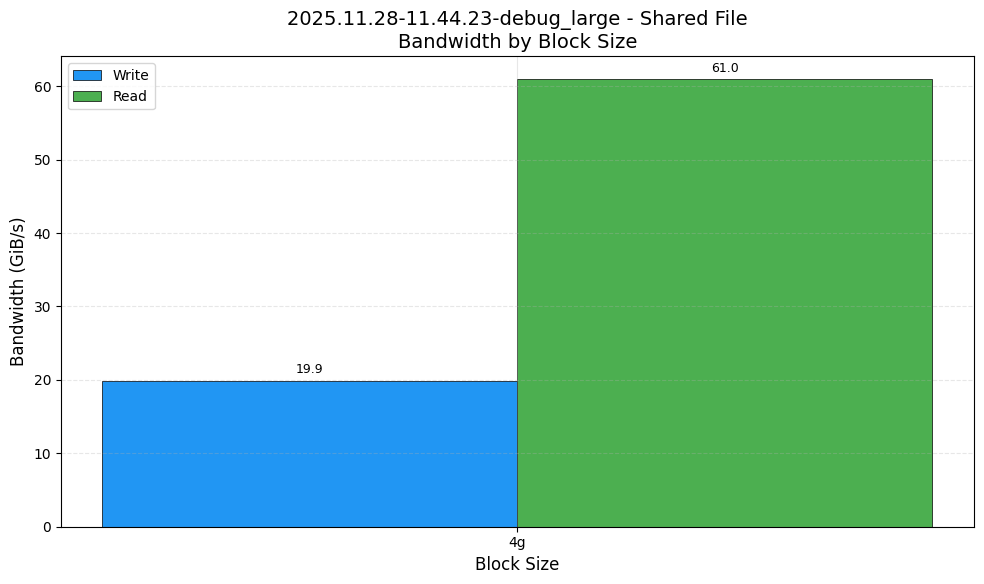

In [10]:
if filtered_detail_df.is_empty() or not SELECTED_EXPERIMENTS:
    print("No data to plot.")
else:
    # Handle both single and multiple experiments
    if len(SELECTED_EXPERIMENTS) == 1:
        exp_df = filtered_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENTS[0])
        experiment_label = SELECTED_EXPERIMENTS[0]
    else:
        exp_df = filtered_detail_df
        experiment_label = f"{len(SELECTED_EXPERIMENTS)} experiments"
    
    for access_mode in ["File-per-Process", "Shared File"]:
        mode_df = exp_df.filter(pl.col("access_mode") == access_mode)
        if mode_df.is_empty():
            continue
            
        # Group by block size and operation
        grouped = (
            mode_df
            .group_by(["block_size_str", "operation"])
            .agg([
                pl.col("bw_gib").mean().alias("bw_gib_mean"),
                pl.col("bw_gib").std().alias("bw_gib_std"),
                pl.col("bw_mib").mean().alias("bw_mib_mean"),
            ])
            .sort("block_size_str")
        )
        
        # Pivot for plotting
        pivot_df = grouped.pivot(
            values="bw_gib_mean",
            index="block_size_str",
            columns="operation"
        ).to_pandas().set_index("block_size_str")
        
        # Sort by block size
        size_order = ['64m', '256m', '512m', '1g', '2g', '4g']
        pivot_df = pivot_df.reindex([s for s in size_order if s in pivot_df.index])
        
        if pivot_df.empty:
            continue
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        x = range(len(pivot_df))
        width = 0.35
        
        colors = {'write': '#2196F3', 'read': '#4CAF50'}
        
        if 'write' in pivot_df.columns:
            ax.bar([i - width/2 for i in x], pivot_df['write'], width, 
                   label='Write', color=colors['write'], edgecolor='black', linewidth=0.5)
        if 'read' in pivot_df.columns:
            ax.bar([i + width/2 for i in x], pivot_df['read'], width,
                   label='Read', color=colors['read'], edgecolor='black', linewidth=0.5)
        
        ax.set_xlabel('Block Size')
        ax.set_ylabel('Bandwidth (GiB/s)')
        ax.set_title(f'{experiment_label} - {access_mode}\nBandwidth by Block Size')
        ax.set_xticks(x)
        ax.set_xticklabels(pivot_df.index)
        ax.legend(loc='upper left')
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        # Add value labels on bars
        for bars in ax.containers:
            ax.bar_label(bars, fmt='%.1f', padding=3, fontsize=9)
        
        plt.tight_layout()
        save(fig, f"bandwidth_by_blocksize_{slugify(experiment_label)}_{slugify(access_mode)}")
        plt.show()
        plt.close(fig)

## Bandwidth by Transfer Size

転送サイズ (transfer_size) 別のRead/Write帯域を比較します。

In [11]:
if filtered_detail_df.is_empty() or not SELECTED_EXPERIMENTS:
    print("No data to plot.")
else:
    # Handle both single and multiple experiments
    if len(SELECTED_EXPERIMENTS) == 1:
        exp_df = filtered_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENTS[0])
        experiment_label = SELECTED_EXPERIMENTS[0]
    else:
        exp_df = filtered_detail_df
        experiment_label = f"{len(SELECTED_EXPERIMENTS)} experiments"
    
    for access_mode in ["File-per-Process", "Shared File"]:
        mode_df = exp_df.filter(pl.col("access_mode") == access_mode)
        if mode_df.is_empty():
            continue
            
        # Group by transfer size and operation
        grouped = (
            mode_df
            .group_by(["transfer_size_str", "operation"])
            .agg([
                pl.col("bw_gib").mean().alias("bw_gib_mean"),
                pl.col("bw_gib").std().alias("bw_gib_std"),
                pl.len().alias("samples"),
            ])
            .sort("transfer_size_str")
        )
        
        # Get unique transfer sizes
        transfer_sizes = grouped["transfer_size_str"].unique().to_list()
        
        if len(transfer_sizes) < 2:
            print(f"{access_mode}: Only {len(transfer_sizes)} transfer size(s), skipping comparison plot.")
            continue
        
        # Pivot for plotting
        pivot_df = grouped.pivot(
            values="bw_gib_mean",
            index="transfer_size_str",
            columns="operation"
        ).to_pandas().set_index("transfer_size_str")
        
        # Also get std for error bars
        std_pivot = grouped.pivot(
            values="bw_gib_std",
            index="transfer_size_str",
            columns="operation"
        ).to_pandas().set_index("transfer_size_str")
        
        # Sort by transfer size
        size_order = ['1k', '4k', '16k', '64k', '256k', '1m', '4m', '16m', '64m', '256m', '1g']
        pivot_df = pivot_df.reindex([s for s in size_order if s in pivot_df.index])
        std_pivot = std_pivot.reindex([s for s in size_order if s in std_pivot.index])
        
        if pivot_df.empty:
            continue
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        x = range(len(pivot_df))
        width = 0.35
        
        colors = {'write': '#2196F3', 'read': '#4CAF50'}
        
        if 'write' in pivot_df.columns:
            yerr_write = std_pivot['write'].fillna(0) if 'write' in std_pivot.columns else None
            ax.bar([i - width/2 for i in x], pivot_df['write'], width,
                   yerr=yerr_write, capsize=3,
                   label='Write', color=colors['write'], edgecolor='black', linewidth=0.5)
        if 'read' in pivot_df.columns:
            yerr_read = std_pivot['read'].fillna(0) if 'read' in std_pivot.columns else None
            ax.bar([i + width/2 for i in x], pivot_df['read'], width,
                   yerr=yerr_read, capsize=3,
                   label='Read', color=colors['read'], edgecolor='black', linewidth=0.5)
        
        ax.set_xlabel('Transfer Size')
        ax.set_ylabel('Bandwidth (GiB/s)')
        ax.set_title(f'{experiment_label} - {access_mode}\nBandwidth by Transfer Size')
        ax.set_xticks(x)
        ax.set_xticklabels(pivot_df.index)
        ax.legend(loc='upper left')
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        # Add value labels on bars (only for BarContainers)
        for container in ax.containers:
            if hasattr(container, 'patches'):
                ax.bar_label(container, fmt='%.1f', padding=3, fontsize=9)
        
        plt.tight_layout()
        save(fig, f"bandwidth_by_transfer_size_{slugify(experiment_label)}_{slugify(access_mode)}")
        plt.show()
        plt.close(fig)

Shared File: Only 1 transfer size(s), skipping comparison plot.


## Scalability Analysis

ノード数・プロセス数に対するスケーラビリティを確認します。

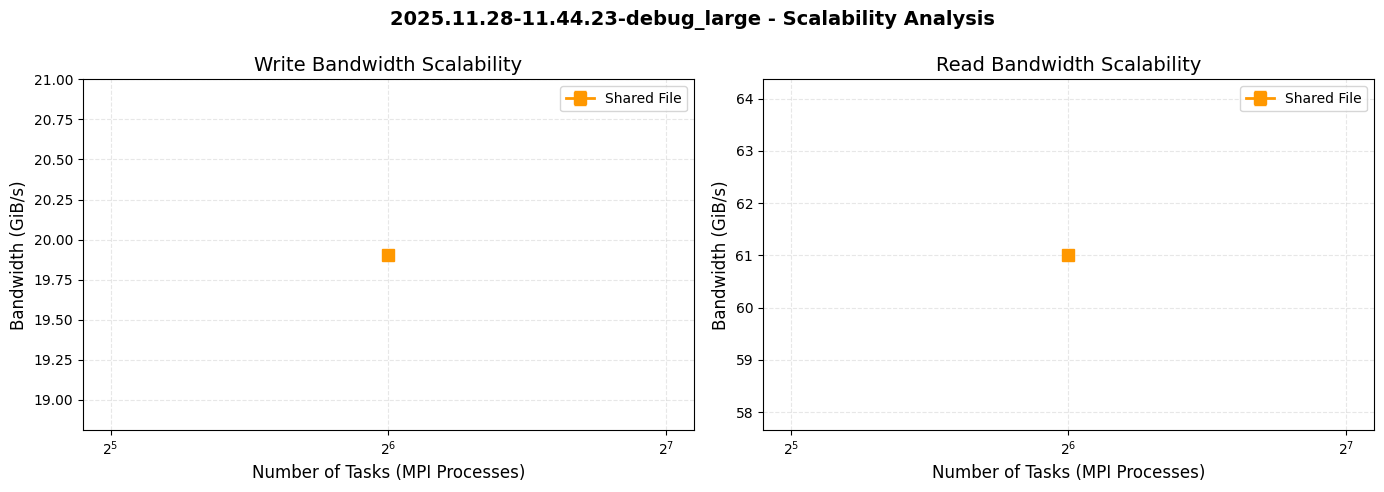

In [12]:
if filtered_detail_df.is_empty() or not SELECTED_EXPERIMENTS:
    print("No data to plot.")
else:
    # Handle both single and multiple experiments
    if len(SELECTED_EXPERIMENTS) == 1:
        exp_df = filtered_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENTS[0])
        experiment_label = SELECTED_EXPERIMENTS[0]
    else:
        exp_df = filtered_detail_df
        experiment_label = f"{len(SELECTED_EXPERIMENTS)} experiments"
    
    # Group by num_tasks and operation
    scalability = (
        exp_df
        .group_by(["num_tasks", "operation", "access_mode"])
        .agg([
            pl.col("bw_gib").mean().alias("bw_gib_mean"),
            pl.col("bw_gib").std().alias("bw_gib_std"),
            pl.col("nodes").first().alias("nodes"),
        ])
        .sort("num_tasks")
    )
    
    if scalability.is_empty():
        print("No scalability data available.")
    else:
        pdf = scalability.to_pandas()
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        for ax, operation in zip(axes, ['write', 'read']):
            op_df = pdf[pdf['operation'] == operation]
            
            for access_mode, marker, color in [('File-per-Process', 'o', '#2196F3'), ('Shared File', 's', '#FF9800')]:
                mode_df = op_df[op_df['access_mode'] == access_mode]
                if mode_df.empty:
                    continue
                ax.errorbar(
                    mode_df['num_tasks'],
                    mode_df['bw_gib_mean'],
                    yerr=mode_df['bw_gib_std'].fillna(0),
                    marker=marker,
                    markersize=8,
                    linewidth=2,
                    capsize=4,
                    label=access_mode,
                    color=color,
                )
            
            ax.set_xlabel('Number of Tasks (MPI Processes)')
            ax.set_ylabel('Bandwidth (GiB/s)')
            ax.set_title(f'{operation.capitalize()} Bandwidth Scalability')
            ax.legend()
            ax.grid(alpha=0.3, linestyle='--')
            ax.set_xscale('log', base=2)
        
        fig.suptitle(f'{experiment_label} - Scalability Analysis', fontsize=14, fontweight='bold')
        plt.tight_layout()
        save(fig, f"scalability_{slugify(experiment_label)}")
        plt.show()
        plt.close(fig)

## Read vs Write Comparison

Read/Writeの帯域比較を散布図で可視化します。

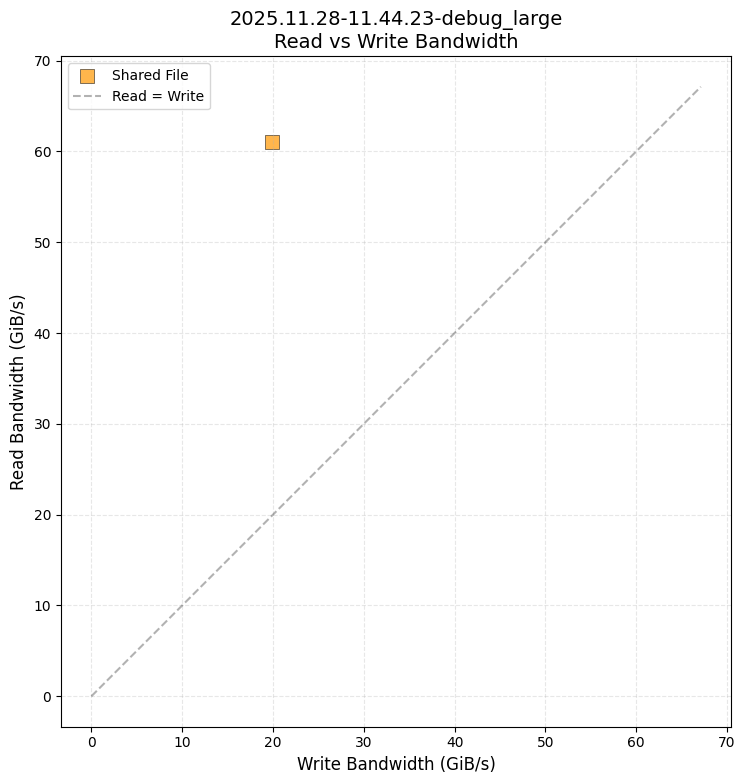

In [13]:
if filtered_detail_df.is_empty() or not SELECTED_EXPERIMENTS:
    print("No data to plot.")
else:
    # Handle both single and multiple experiments
    if len(SELECTED_EXPERIMENTS) == 1:
        exp_df = filtered_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENTS[0])
        experiment_label = SELECTED_EXPERIMENTS[0]
    else:
        exp_df = filtered_detail_df
        experiment_label = f"{len(SELECTED_EXPERIMENTS)} experiments"
    
    # Get write and read data per run
    write_df = exp_df.filter(pl.col("operation") == "write").select(
        "run_index", "access_mode", "block_size_str", "num_tasks",
        pl.col("bw_gib").alias("write_bw_gib")
    )
    read_df = exp_df.filter(pl.col("operation") == "read").select(
        "run_index", "access_mode", "block_size_str", "num_tasks",
        pl.col("bw_gib").alias("read_bw_gib")
    )
    
    merged = write_df.join(
        read_df,
        on=["run_index", "access_mode", "block_size_str", "num_tasks"],
        how="inner"
    ).to_pandas()
    
    if merged.empty:
        print("No paired write/read data available.")
    else:
        fig, ax = plt.subplots(figsize=(8, 8))
        
        colors = {'File-per-Process': '#2196F3', 'Shared File': '#FF9800'}
        markers = {'File-per-Process': 'o', 'Shared File': 's'}
        
        for mode in merged['access_mode'].unique():
            mode_df = merged[merged['access_mode'] == mode]
            ax.scatter(
                mode_df['write_bw_gib'],
                mode_df['read_bw_gib'],
                c=colors.get(mode, 'gray'),
                marker=markers.get(mode, 'o'),
                s=100,
                alpha=0.7,
                edgecolors='black',
                linewidths=0.5,
                label=mode
            )
        
        # Add diagonal line (read = write)
        max_val = max(merged['write_bw_gib'].max(), merged['read_bw_gib'].max()) * 1.1
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='Read = Write')
        
        ax.set_xlabel('Write Bandwidth (GiB/s)')
        ax.set_ylabel('Read Bandwidth (GiB/s)')
        ax.set_title(f'{experiment_label}\nRead vs Write Bandwidth')
        ax.legend()
        ax.grid(alpha=0.3, linestyle='--')
        ax.set_aspect('equal')
        
        plt.tight_layout()
        save(fig, f"read_vs_write_{slugify(experiment_label)}")
        plt.show()
        plt.close(fig)

## Bandwidth by Run Index

同一ジョブ内の run_index ごとの帯域推移を確認します。

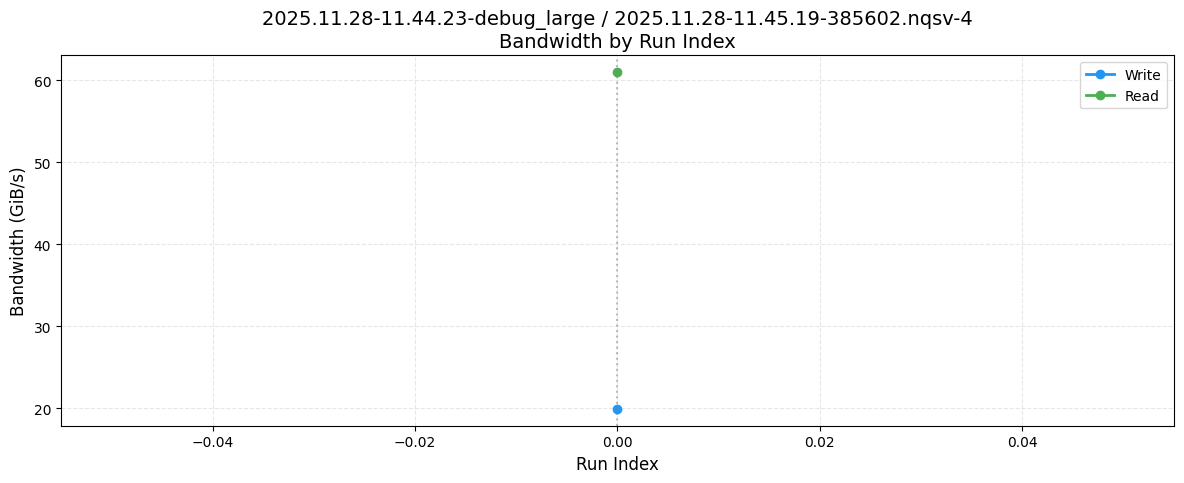

In [14]:
if filtered_detail_df.is_empty() or not SELECTED_EXPERIMENTS:
    print("No IOR data to plot.")
else:
    # Handle both single and multiple experiments
    if len(SELECTED_EXPERIMENTS) == 1:
        exp_df = filtered_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENTS[0])
        experiment_label = SELECTED_EXPERIMENTS[0]
    else:
        exp_df = filtered_detail_df
        experiment_label = f"{len(SELECTED_EXPERIMENTS)} experiments"
    
    for run_df in exp_df.partition_by("run", maintain_order=True):
        run = run_df[0, "run"] or "unknown"
        
        tidy = (
            run_df
            .select("run_index", "operation", "bw_gib", "access_mode", "block_size_str")
            .drop_nulls("bw_gib")
            .sort(["operation", "run_index"])
        ).to_pandas()
        
        if tidy.empty:
            continue
        
        fig, ax = plt.subplots(figsize=(12, 5))
        
        colors = {'write': '#2196F3', 'read': '#4CAF50'}
        
        for operation in ['write', 'read']:
            op_df = tidy[tidy['operation'] == operation]
            ax.plot(
                op_df['run_index'],
                op_df['bw_gib'],
                marker='o',
                linewidth=2,
                markersize=6,
                label=operation.capitalize(),
                color=colors[operation],
            )
        
        ax.set_xlabel('Run Index')
        ax.set_ylabel('Bandwidth (GiB/s)')
        ax.set_title(f'{experiment_label} / {run}\nBandwidth by Run Index')
        ax.grid(alpha=0.3, linestyle='--')
        ax.legend()
        
        # Add annotations for configuration changes
        prev_config = None
        for _, row in tidy[tidy['operation'] == 'write'].iterrows():
            config = f"{row['block_size_str']}/{row['access_mode'][:1]}"
            if config != prev_config:
                ax.axvline(x=row['run_index'], color='gray', linestyle=':', alpha=0.5)
                prev_config = config
        
        plt.tight_layout()
        save(fig, f"bandwidth_run_index_{slugify(experiment_label)}_{slugify(run)}")
        plt.show()
        plt.close(fig)

## Summary Statistics Table

実験の統計サマリを表形式で表示します。

In [15]:
if filtered_detail_df.is_empty() or not SELECTED_EXPERIMENTS:
    print("No data available.")
else:
    exp_df = filtered_detail_df
    
    stats = (
        exp_df
        .group_by(["experiment", "access_mode", "operation", "block_size_str"])
        .agg([
            pl.col("bw_gib").mean().round(2).alias("Mean (GiB/s)"),
            pl.col("bw_gib").max().round(2).alias("Max (GiB/s)"),
            pl.col("bw_gib").min().round(2).alias("Min (GiB/s)"),
            pl.col("bw_gib").std().round(2).alias("Std (GiB/s)"),
            pl.len().alias("Samples"),
        ])
        .sort(["experiment", "access_mode", "operation", "block_size_str"])
    )
    
    experiment_label = SELECTED_EXPERIMENTS[0] if len(SELECTED_EXPERIMENTS) == 1 else f"{len(SELECTED_EXPERIMENTS)} experiments"
    print(f"\n{experiment_label} - Summary Statistics\n")
    display(stats.to_pandas())


2025.11.28-11.44.23-debug_large - Summary Statistics



,experiment,access_mode,operation,block_size_str,Mean (GiB/s),Max (GiB/s),Min (GiB/s),Std (GiB/s),Samples
0,2025.11.28-11.44.23-debug_large,Shared File,read,4g,61.01,61.01,61.01,NaN,1
1,2025.11.28-11.44.23-debug_large,Shared File,write,4g,19.91,19.91,19.91,NaN,1


## Export Processed Data

整形済みのサマリと詳細データをJSONとして保存します。

In [16]:
if filtered_summary_df.is_empty() and filtered_detail_df.is_empty():
    print("No IOR results to export.")
else:
    experiment_suffix = "_".join(slugify(e) for e in SELECTED_EXPERIMENTS) if SELECTED_EXPERIMENTS else "all"
    
    if not filtered_summary_df.is_empty():
        summary_out = DATA_DIR / f"ior_summary_{experiment_suffix}.json"
        summary_out.parent.mkdir(parents=True, exist_ok=True)
        summary_out.write_text(
            json.dumps(filtered_summary_df.to_pandas().to_dict(orient="records"), ensure_ascii=False, indent=2)
        )
        print(f"Wrote {summary_out}")
    else:
        print("No summary records to export.")
        
    if not filtered_detail_df.is_empty():
        detail_out = DATA_DIR / f"ior_detail_{experiment_suffix}.json"
        detail_out.parent.mkdir(parents=True, exist_ok=True)
        detail_out.write_text(
            json.dumps(filtered_detail_df.to_pandas().to_dict(orient="records"), ensure_ascii=False, indent=2)
        )
        print(f"Wrote {detail_out}")
    else:
        print("No detailed records to export.")

Wrote /work/0/NBB/rmaeda/workspace/rust/benchfs/plot/processed/benchfsd/ior_summary_2025.11.28-11.44.23-debug_large.json
Wrote /work/0/NBB/rmaeda/workspace/rust/benchfs/plot/processed/benchfsd/ior_detail_2025.11.28-11.44.23-debug_large.json
